<h1><center>CS 455/595a: Ensemble Methods - bagging and random forests</center></h1>
<center>Richard S. Stansbury</center>

This notebook applies the bagging and random forest ensemble classification and regression concepts concepts covered in [1] with the [Titanic](https://www.kaggle.com/c/titanic/) and [Boston Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) data sets for DT-based classification and regression, respectively.

Note: you must install the graphviz package for Python.  Please do this install using pip or conda. i.e.  "conda install graphviz"

Reference:

[1] Aurelen Geron. *Hands on Machine Learning with Scikit-Learn & TensorFlow* O'Reilley Media Inc, 2017.

[2] Aurelen Geron. "ageron/handson-ml: A series of Jupyter notebooks that walk you through the fundamentals of Machine Learning and Deep Learning in python using Scikit-Learn and TensorFlow." Github.com, online at: https://github.com/ageron/handson-ml [last accessed 2019-03-01]

**Table of Contents**
1. [Titanic Survivor Ensemble Classifiers](#Titanic-Survivor-Classifier)
 
2. [Boston Housing Cost Ensemble Regressors](#Boston-Housing-Cost-Estimator)

# Titanic Survivor Classifier

## Set up - Imports of libraries and Data Preparation

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn import datasets

from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import os

# Read data from input files into Pandas data frames
data_path = os.path.join("datasets","titanic")
train_filename = "train.csv"
test_filename = "test.csv"

def read_csv(data_path, filename):
    joined_path = os.path.join(data_path, filename)
    return pd.read_csv(joined_path)

# Read CSV file into Pandas Dataframes
train_df = read_csv(data_path, train_filename)

# Defining Data Pre-Processing Pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], 
                                       index = X.columns)
        return self
    
    def transform(self, X):
        return X.fillna(self.most_frequent)

    
numeric_pipe = Pipeline([
        ("Select", DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])), # Selects Fields from dataframe
        ("Imputer", SimpleImputer(strategy="median")),   # Fills in NaN w/ median value for its column
    ])

#Handle categorical string for sex by encoding as female true, 1 or false,0
train_df['Female'] = train_df["Sex"].apply(lambda x: 1 if x == 'female' else 0)

categories_pipe = Pipeline([
        ("Select", DataFrameSelector(["Pclass", "Female"])), # Selects Fields from dataframe
        ("MostFreqImp", MostFrequentImputer()), # Fill in NaN with most frequent
    ])

preprocessing_pipe = FeatureUnion(transformer_list = [
        ("numeric pipeline", numeric_pipe), 
        ("categories pipeline", categories_pipe)
     ]) 

# Process Input Data Using Pipleines
train_X_data = preprocessing_pipe.fit_transform(train_df)

train_y_data = train_df["Survived"]

feature_names = ["Age", "Fare", "SibSp", "Parch", "Class", "Female"]
target_names = ["Died","Survived"]

## KNN Classifier Performance vs. Metrics (for comparison)

This example is included for comparison by showing the cross validation metric scores for a KNN classifier on the titanic data set.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier 10-fold Validation
k=10
clf = KNeighborsClassifier(n_neighbors=k)

y_pred = cross_val_predict(clf, train_X_data, train_y_data, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))                            
                               

Confusion Matrix:
[[451  98]
 [176 166]]
Accuracy Score = 0.6924803591470258
Pecision Score = 0.6287878787878788
Recall Score = 0.4853801169590643
F1 Score = 0.5478547854785478


## Bagging Example with KNN

This example implements a bagging classifier of 500 KNN classifiers with K=10.  It then demonstrates the performance metrics for the algorithm under a 5-fold cross validation.

In [3]:
from sklearn.ensemble import BaggingClassifier

k=10
base_clf = KNeighborsClassifier(n_neighbors=k)

bag_clf = BaggingClassifier(
    base_clf,
    n_estimators = 500,
    max_samples=0.5, 
    n_jobs = -1,
    bootstrap=True)
    
y_pred = cross_val_predict(bag_clf, train_X_data, train_y_data, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   



Confusion Matrix:
[[476  73]
 [182 160]]
Accuracy Score = 0.7138047138047138
Pecision Score = 0.6866952789699571
Recall Score = 0.4678362573099415
F1 Score = 0.5565217391304348


## Bagging with Decision Tree

This example implements a bagging classifier of 500 decision trees (constrained to a maximum depth of 10 each).  It then demonstrates the performance metrics for the algorithm under a 5-fold cross validation.

In [4]:
from sklearn.tree import DecisionTreeClassifier

k=10
base_clf = DecisionTreeClassifier(max_depth=10)

bag_clf = BaggingClassifier(
    base_clf,
    n_estimators = 500,
    max_samples=0.5, 
    n_jobs = -1,
    bootstrap=True)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(bag_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Confusion Matrix:
[[494  55]
 [ 95 247]]
Accuracy Score = 0.8316498316498316
Pecision Score = 0.8178807947019867
Recall Score = 0.7222222222222222
F1 Score = 0.767080745341615


## Out of Bag Validation

This examples creates a bagging method ensemble classifier with decision trees up to depth 10.  It is configured to output the oob_score, which is the cross validation score.  


In [5]:
from sklearn.tree import DecisionTreeClassifier

k=10
base_clf = DecisionTreeClassifier(max_depth=10)

bag_clf = BaggingClassifier(
    base_clf,
    n_estimators = 500,
    max_samples=0.5, 
    n_jobs = -1,
    oob_score=True,
    bootstrap=True)

bag_clf.fit(train_X_data, train_y_data)
bag_clf.oob_score_

0.8372615039281706

## Random Forest Example

This examples creates a random forest of decision tree cassifiers of 500 estimators with a maximum depth limit of 10 for each.

The output shows the cross validation confusion matrix and the performance metrics.

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(rf_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Confusion Matrix:
[[489  60]
 [ 93 249]]
Accuracy Score = 0.8282828282828283
Pecision Score = 0.8058252427184466
Recall Score = 0.7280701754385965
F1 Score = 0.7649769585253456


## Feature Importance and Out of Bag Validation for Random Forest

This example demonstrates a random forest classifier with the oob_score turned to true.

We output from it the importance score for each feature.  We also output the out of bag cross validation score.

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10, oob_score=True)
rf_clf.fit(train_X_data, train_y_data)

for name, score in zip(feature_names, rf_clf.feature_importances_):
    print(name, score)
    
print("\n\nOut of Bag Validation:", rf_clf.oob_score_)

Age 0.21521485666499743
Fare 0.2531162616497593
SibSp 0.05279198742110052
Parch 0.04114965201108518
Class 0.10626020473669949
Female 0.33146703751635787


Out of Bag Validation: 0.8316498316498316


## AdaBoost

This examples creates a Adaboost classifier ensemble of 100 decision trees using the SAMME.R algorithm and a learning rate of 1.0.  

The output shows the cross validation confusion matrix and the performance metrics.  Note the similar performance to the previous ensemble, but with lower precision and recall showing that the model is overfitting a bit.

In [8]:
# Adaboost goes here
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=1.0)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(ada_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Confusion Matrix:
[[466  83]
 [ 88 254]]
Accuracy Score = 0.8080808080808081
Pecision Score = 0.7537091988130564
Recall Score = 0.7426900584795322
F1 Score = 0.748159057437408


## Gradient Boost Decision Tree Classifier

This examples creates a Gradient Boosting Decision Tree Classifier classifier ensemble of decision trees with max depth=5 and 100 estimators in sequence.

The output shows the cross validation confusion matrix and the performance metrics.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier


gb_clf = GradientBoostingClassifier(max_depth=5, n_estimators=100)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(gb_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Confusion Matrix:
[[493  56]
 [ 95 247]]
Accuracy Score = 0.8305274971941639
Pecision Score = 0.8151815181518152
Recall Score = 0.7222222222222222
F1 Score = 0.7658914728682169


## Gradient Boost Decision Tree Classifier with Early Stopping

This examples creates a Gradient Boosting Decision Tree Classifier classifier ensemble of decision trees of max depth = 5 and using early stopping to determine the number of estimators that produced the best results.

The output shows the cross validation confusion matrix and the performance metrics of a model with the optimal number of estimators.

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the training into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_X_data, train_y_data)

max_tree_depth=5

gb_clf = GradientBoostingClassifier(max_depth=max_tree_depth, n_estimators=1000)

gb_clf.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gb_clf.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

print("Best Number of Estimators:" + str(bst_n_estimators))

gb_clf = GradientBoostingClassifier(max_depth=max_tree_depth, n_estimators=bst_n_estimators)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(gb_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Best Number of Estimators:1
Confusion Matrix:
[[549   0]
 [342   0]]
Accuracy Score = 0.6161616161616161
Pecision Score = 0.0
Recall Score = 0.0
F1 Score = 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Boston Housing Cost Estimator

Building off the classifier examples above, this section shows ensemble regressors using bagging and random forests.

## Setup

In [11]:
# Load Data Set
boston_housing_data = datasets.load_boston()

train_X, test_X, train_y, test_y = train_test_split(boston_housing_data.data,
                                                   boston_housing_data.target,
                                                   test_size=0.33)

def plot_learning_curves(model, X, y):
    """
    Plots performance on the training set and testing (validation) set.
    X-axis - number of training samples used
    Y-axis - RMSE
    """
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20)
    
    training_errors, validation_errors = [], []
    
    for m in range(1, len(train_X)):
        
        model.fit(train_X[:m], train_y[:m])
        
        train_pred = model.predict(train_X)
        test_pred = model.predict(test_X)
        
        training_errors.append(np.sqrt(mean_squared_error(train_y, train_pred)))
        validation_errors.append(np.sqrt(mean_squared_error(test_y, test_pred)))
        
    plt.plot(training_errors, "r-+", label="train")
    plt.plot(validation_errors, "b-", label="test")
    plt.legend()
    plt.axis([0, 80, 0, 3])

## Linear Regression on Boston Data Set (for comparison)

For comparison a linear regression on the boston data is shown.

Theta:
43.44159166202052 [-8.83066353e-02  5.53791507e-02  3.81062326e-02  3.27820469e+00
 -1.84635676e+01  2.88679227e+00  2.25111746e-02 -1.41939821e+00
  2.78916263e-01 -9.53207489e-03 -9.98157342e-01  7.78039322e-03
 -7.08579869e-01]
MAE = 3.611434304017275


[0, 300, 0, 10]

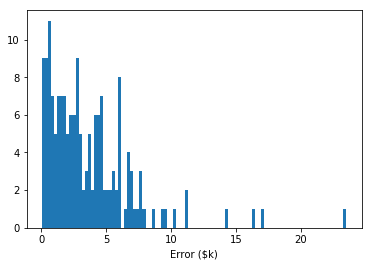

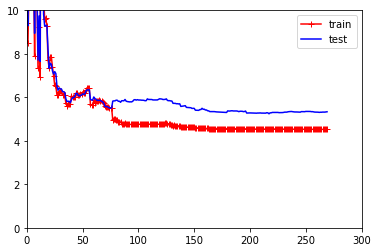

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X,train_y)
pred_y = lin_reg.predict(test_X)

# Outputs the intercept and coefficient of the model (theta_0 and theta_1 respectively)
print("Theta:")
print(lin_reg.intercept_, lin_reg.coef_)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(lin_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Bagging Regressor using Linear Regression as Base

This example implements a bagging regressor with a linear regression model as the base classifier.  It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

Theta:
43.71621547075837 [-1.22260195e-01  5.98901971e-02  1.83813470e-02  2.04990220e+00
 -1.92725889e+01  2.71925778e+00  3.38915334e-02 -1.31998123e+00
  3.35202021e-01 -9.60052031e-03 -1.00192531e+00  8.98182991e-03
 -7.45261667e-01]
MAE = 3.6114343040172847


[0, 300, 0, 10]

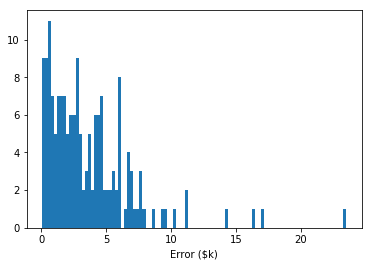

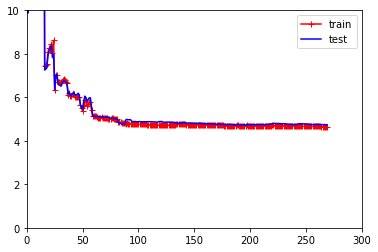

In [13]:
## Bagging with Linear Regression

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

base_reg = LinearRegression()

bag_reg = BaggingRegressor(
    base_reg,
    n_estimators = 500,
    max_samples=1.0,
    n_jobs = -1,
    bootstrap=False) #Not replacement for this configuration

bag_reg.fit(train_X, train_y)

pred_y = bag_reg.predict(test_X)

# Outputs the intercept and coefficient of the model (theta_0 and theta_1 respectively)
print("Theta:")
print(lin_reg.intercept_, lin_reg.coef_)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(lin_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Random Forest Regression Example

This example implements a random forest regressor using decision trees up to depth 10.  It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

MAE = 2.329268855538692


[0, 300, 0, 10]

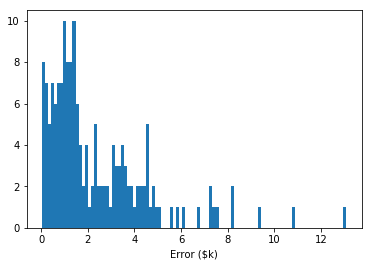

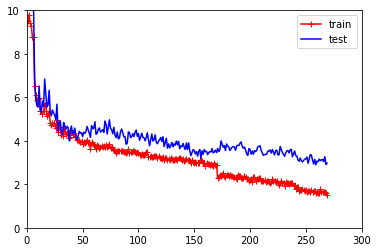

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=10)
rf_reg.fit(train_X, train_y)
pred_y = rf_reg.predict(test_X)


plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(rf_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Random Forest Regressor: Feature Importance and Out of Bag Validation Score

This example shows a random forest regressor using decision trees constrained to a maximum depth of 10.  Out of bag score is enabled.  

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_depth=10, oob_score=True)
rf_reg.fit(train_X, train_y)

for name, score in zip(boston_housing_data.feature_names, rf_reg.feature_importances_):
    print(name, score)
    
print("\n\nOut of Bag Validation:", rf_reg.oob_score_)

CRIM 0.03022049544786123
ZN 0.0009569044273726661
INDUS 0.005347283625153467
CHAS 0.0006749682429345027
NOX 0.017733912256212386
RM 0.23146353753687118
AGE 0.01427746050776671
DIS 0.046999676257769886
RAD 0.0034388034541343194
TAX 0.009612029541723818
PTRATIO 0.022694311444028465
B 0.01028444622723405
LSTAT 0.606296171030937


Out of Bag Validation: 0.8638844692355463


## AdaBoost Regression Example

Implmentation of an AdaBoost ensemble regressor with decision trees of max depth = 2 and 100 estimators in sequence.  Learning rate is decreased to 0.2 to improve generalization.  

This example implements an AdaBoost regressor.  It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

MAE = 4.041440990280153


[0, 300, 0, 10]

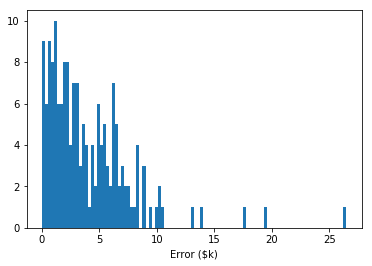

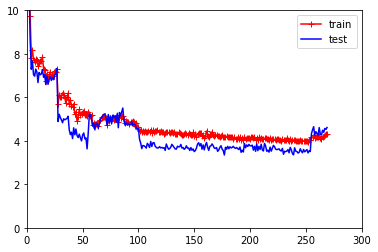

In [16]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#Ada Boost Regressor 
reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=2), 
    n_estimators=100,
    learning_rate=0.2)

reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(reg, train_X, train_y)
plt.axis([0,300,0,10])

## Gradient Boosting Regressor Example

This example implements an Gradient Boosting regressor.  Its ensemble of 200 estimators are decision stumps.


It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

MAE = 2.4564812109848697


[0, 300, 0, 10]

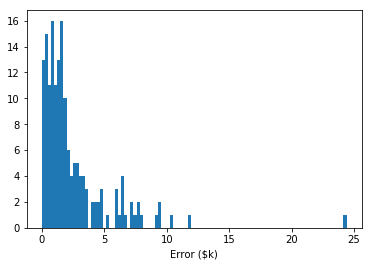

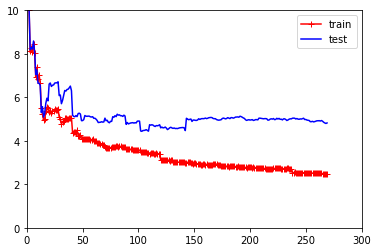

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(max_depth=1, n_estimators=200)

reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(reg, train_X, train_y)
plt.axis([0,300,0,10])

## Gradient Boosting Regressor Example with early stopping

This example implements an Gradient Boosting regressor with early stopping enabled.  It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

Best Number of Estimators:565
MAE = 2.4402850440846033


[0, 300, 0, 10]

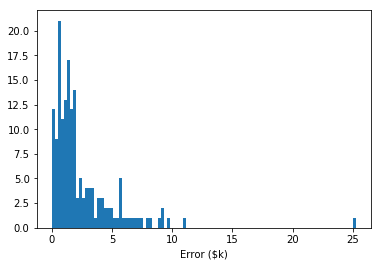

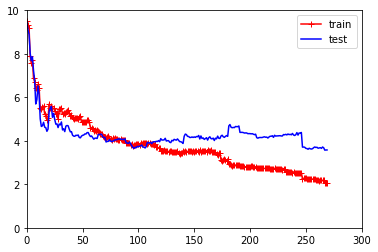

In [19]:
from sklearn.ensemble import GradientBoostingRegressor


# Split the training into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_X_data, train_y_data)

max_tree_depth=1

reg = GradientBoostingRegressor(max_depth=max_tree_depth, n_estimators=1000)
reg.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in reg.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

print("Best Number of Estimators:" + str(bst_n_estimators))

reg = GradientBoostingRegressor(max_depth=max_tree_depth, n_estimators=bst_n_estimators)

##

reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(reg, train_X, train_y)
plt.axis([0,300,0,10])